In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction 

This is the baseline model run on train and validation to give a baseline value to compare against. 
We use the combined strings column and the default blair model as the embedder. 

# Imports 

In [59]:
import os
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists, create_user_df
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation
from utils.graph_model import Base_GNN_Model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set seed

In [60]:
seed_everything()

# Set variables 

In [61]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_base"
user_embed_name = "user_reviews_features_base"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"
results_folder = "baseline"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

# Load data

In [62]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [63]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

In [64]:
# Add the embedding 
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Make super user df
user_df = create_user_df(train_user_df, test_user_df)

In [65]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [66]:
# Concat product nodes 
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [67]:
# concat user nodes 
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [68]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU 

In [69]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Instantiate the model

In [70]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
embedding_dim = 64

In [71]:
# Instantiate the model
model = Base_GNN_Model(num_users, num_products, user_feature_dim, product_feature_dim, embedding_dim)

In [72]:
# move the model 
model.to(device)

Base_GNN_Model(
  (user_embedding): Embedding(383703, 64)
  (product_embedding): Embedding(89060, 64)
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train the model 

In [73]:
train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights, 
                                                 user_nodes, product_nodes, num_epochs = 1000, print_progress=True, print_freq=100)

Epoch: 100, Train Loss: 4.7544, Val Loss: 4.6752, best model epoch: 87
Epoch: 200, Train Loss: 4.4551, Val Loss: 4.6062, best model epoch: 193
Epoch: 300, Train Loss: 4.7274, Val Loss: 4.0712, best model epoch: 292
Epoch: 400, Train Loss: 3.9642, Val Loss: 3.7962, best model epoch: 388
Epoch: 500, Train Loss: 3.2847, Val Loss: 3.7623, best model epoch: 492
Epoch: 600, Train Loss: 2.7262, Val Loss: 2.4391, best model epoch: 593
Epoch: 700, Train Loss: 2.2567, Val Loss: 2.0372, best model epoch: 694
Epoch: 800, Train Loss: 2.1882, Val Loss: 1.8052, best model epoch: 753
Epoch: 900, Train Loss: 1.9255, Val Loss: 1.5887, best model epoch: 882
Epoch: 1000, Train Loss: 1.5171, Val Loss: 1.3512, best model epoch: 1000


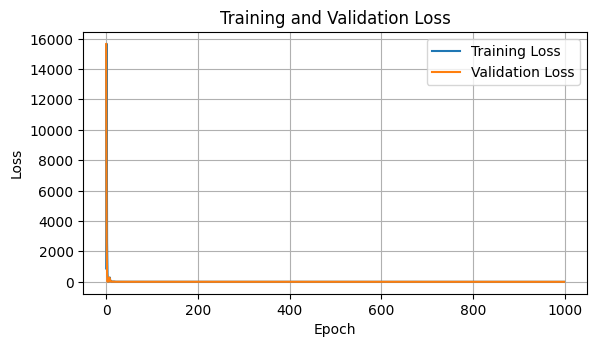

In [74]:
plot_train_val_loss(train_loss, test_loss)

In [75]:
os.makedirs("results/baseline", exist_ok=True)
torch.save(train_loss, f"results/{results_folder}/train_loss.pt")
torch.save(test_loss, f"results/{results_folder}/test_loss.pt")

# Best model performance 

Note this is on the validation set 

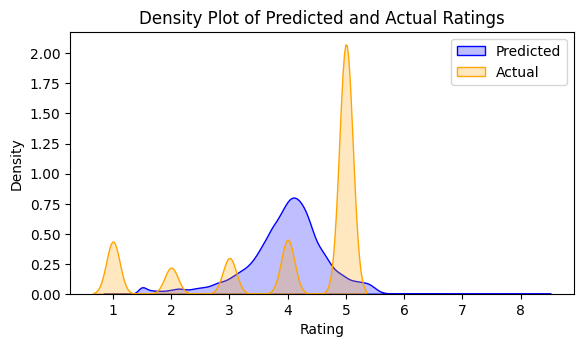

1.351219892501831


In [76]:
model.load_state_dict(best_model)
best_loss, predictions = final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device, plot = True, print_test = False)
print(best_loss.item())

In [77]:
torch.save(predictions, f"results/{results_folder}/predictions.pt")

# Metrics 

In [78]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [79]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [80]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [81]:
# Only those with prior history 
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [82]:
test_edges_grp.to_parquet(f"results/{results_folder}/predictions.parquet")

# Show sample recomendations 

In [83]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [84]:
# The pure random 
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: AVON Mesmerize Black for Him Eau de Toilette 100ml - 3.4oz
Product 2: Pack of 2 CoverGirl So Lashy blast PRO Mascara, Black/Brown, 810
Product 3: IoYoI White 1 Inch Craft Girls Headband Women's Hair Bands No Teeth DIY Plastic Material Decorative Wide Headwears Clip Adolescent Female (50 pcs)
Product 4: Kiss I Envy Knot Free Trio Medium Ultra Black
Product 5: Leopard Headbands by GNAWRISHING,Fashion Headbands, Knot Dot Hair Bands for Women's Hair Accessories, Cheetah Headband for Girls 3 color with 3 leopard hair ties,6 Pack
Product 6: 2PCS Messy Bun Hair Piece 100% Human Hair Scrunchies Buns Hair Pieces for Women Curly Wavy Black Bun Elegant Chignons Wedding … (2PCS Human hair, Medium Brown).
Product 7: Afro Kinky Curly Clip in for American Lady 12.1" #126
Product 8: Voskhod Double Edge Safety Razor Blades, 100 blades (5x20)
Product 9: Volume Lash Extensions Easy Fan Volume Lashes C Curl Mixed Tray 0.10 Self Fanning Lashes (0.10-C, Mix 8-14mm)
Product 10: Replacement Slide D

In [85]:
# The user with some data 
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [86]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes, 
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: AVON Mesmerize Black for Him Eau de Toilette 100ml - 3.4oz
Product 2: Pack of 2 CoverGirl So Lashy blast PRO Mascara, Black/Brown, 810
Product 3: IoYoI White 1 Inch Craft Girls Headband Women's Hair Bands No Teeth DIY Plastic Material Decorative Wide Headwears Clip Adolescent Female (50 pcs)
Product 4: Kiss I Envy Knot Free Trio Medium Ultra Black
Product 5: Leopard Headbands by GNAWRISHING,Fashion Headbands, Knot Dot Hair Bands for Women's Hair Accessories, Cheetah Headband for Girls 3 color with 3 leopard hair ties,6 Pack
Product 6: Voskhod Double Edge Safety Razor Blades, 100 blades (5x20)
Product 7: 2PCS Messy Bun Hair Piece 100% Human Hair Scrunchies Buns Hair Pieces for Women Curly Wavy Black Bun Elegant Chignons Wedding … (2PCS Human hair, Medium Brown).
Product 8: Nose Hair Trimmer for Men,Electric Facial Ear Hair Clippers 4 in 1,Rechargeable Mute Motor Waterproof Double-Edge Stainless Steel Blades Nose Hair Scissors,Wet/Dry Use Trimming Tool for Men
Product 9: Smini